In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from pydeseq2.dds import DeseqDataSet, DefaultInference
# from pydeseq2.ds import DeseqStats

import decoupler as dc
import pertpy as pt
# ATTENTION: need for perpty of running jupternotbook
%matplotlib inline


import os
from pathlib import Path

from utils import preprocessing
from utils import DEG


BASE_PATH = os.getenv("BASE_PATH_FOR_SAVING")
ADATA_PATH = "/home/gdallagl/myworkdir/XDP/data/_old/XDP_striatum_RNA_final_051925_raw.h5ad" #f"{BASE_PATH}/adata_for_DEG/adata_for_DEG_slidetag.h5ad"
GRADIENT_GENES_PATH="/home/gdallagl/myworkdir/XDP/utils/dorsal_ventral_gradient/exp_by_spline_combined_corr>0.1.csv"

# Save folder fo results
SAVE_FOLDER = "/home/gdallagl/myworkdir/XDP/data/XDP/DEG_results/DEG_zones_by_ct_slidetag"
os.makedirs(SAVE_FOLDER, exist_ok=True)

2026-01-20 19:33:53 | [INFO] cffi mode is CFFI_MODE.ANY
2026-01-20 19:33:53 | [INFO] R home found: /usr/lib/R
2026-01-20 19:33:53 | [INFO] R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-20 19:33:53 | [INFO] LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-20 19:33:53 | [INFO] Default options to initialize R: rpy2, --quiet, --no-save
2026-01-20 19:33:54 | [INFO] Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64"
2026-01-20 19:33:54 

In [2]:
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 247646 × 19967
    obs: 'orig.ident', 'ncount_rna', 'nfeature_rna', 'cell', 'donor_id', 'prob_max', 'numi', 'nread', 'pct_intronic', 'pct_mito', 'library', 'region', 'rna_snn_res.0.2', 'seurat_clusters', 'rna_snn_res.0.3', 'rna_snn_res.0.4', 'rna_snn_res.0.5', 'rna_snn_res.0.6', 'rna_snn_res.0.7', 'rna_snn_res.0.8', 'rna_snn_res.0.9', 'rna_snn_res.1', 'rna_snn_res.0.05', 'rna_snn_res.0.1', 'brain_bank', 'cohort', 'year_collected', 'repeat_length', 'age_of_onset', 'age_of_death', 'disease_duration', 'rqs', 'dv200', 'ph', 'mqs_numerical', 'mqs', 'immediate.cause.of.death', 'infection_related_death', 'sex', 'condition', 'library_cohort', 'cell_id', 'class_label_name', 'class_label_bootstrapping_probability', 'subclass_label_name', 'subclass_label_bootstrapping_probability', 'group_label_name', 'group_label_bootstrapping_probability', 'cluster_label_name', 'cluster_label_bootstrapping_probability', 'cell_class', 'neuron_cell_class', 'phase_c_plus_UCell_

In [3]:
# How many donors for each cll type
donor_counts = (
    adata.obs
    .groupby("group_label_name")["donor_id"]
    .nunique()
    .reset_index(name="n_donors")
)
donor_counts

/tmp/ipykernel_417206/4116568974.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group_label_name")["donor_id"]


,group_label_name,n_donors
0,BAM,47
1,BG SKOR1 Glut,12
2,BN Astrocyte,47
3,BN LAMP5 CXCL14 GABA,45
4,BN LAMP5 LHX6 GABA,26
5,BN MEIS2 GABA,43
6,COP,10
7,Endo,47
8,Ependymal,47
9,GP MEIS2 SOX6 GABA,18


In [4]:
[s for s in adata.obs.group_label_name.unique() if "STR" in s]

['STR Astrocyte',
 'STR TAC3 PLPP4 GABA',
 'STRv D1 NUDAP',
 'STRd D1 Striosome',
 'STRd D1 Matrix',
 'STRd D1D2 Hybrid',
 'STRd D2 Striosome',
 'STRd D2 Matrix',
 'STR Cholinergic GABA',
 'STR SST Chodl GABA',
 'STRv D2 Shell',
 'STR SST RSPO2 GABA',
 'STRv D1 Shell',
 'STRd D2 StrioMat Hybrid',
 'STR FS PTHLH ST18 GABA',
 'STR VIP GABA',
 'STR LHX8 ST18 GABA',
 'STR SST ADARB2 GABA']

In [5]:
adata = adata[adata.obs["group_label_name"] == "STRd D2 Matrix"].copy()
print(adata)
adata.obs.columns

AnnData object with n_obs × n_vars = 9772 × 19967
    obs: 'orig.ident', 'ncount_rna', 'nfeature_rna', 'cell', 'donor_id', 'prob_max', 'numi', 'nread', 'pct_intronic', 'pct_mito', 'library', 'region', 'rna_snn_res.0.2', 'seurat_clusters', 'rna_snn_res.0.3', 'rna_snn_res.0.4', 'rna_snn_res.0.5', 'rna_snn_res.0.6', 'rna_snn_res.0.7', 'rna_snn_res.0.8', 'rna_snn_res.0.9', 'rna_snn_res.1', 'rna_snn_res.0.05', 'rna_snn_res.0.1', 'brain_bank', 'cohort', 'year_collected', 'repeat_length', 'age_of_onset', 'age_of_death', 'disease_duration', 'rqs', 'dv200', 'ph', 'mqs_numerical', 'mqs', 'immediate.cause.of.death', 'infection_related_death', 'sex', 'condition', 'library_cohort', 'cell_id', 'class_label_name', 'class_label_bootstrapping_probability', 'subclass_label_name', 'subclass_label_bootstrapping_probability', 'group_label_name', 'group_label_bootstrapping_probability', 'cluster_label_name', 'cluster_label_bootstrapping_probability', 'cell_class', 'neuron_cell_class', 'phase_c_plus_UCell__R

Index(['orig.ident', 'ncount_rna', 'nfeature_rna', 'cell', 'donor_id',
       'prob_max', 'numi', 'nread', 'pct_intronic', 'pct_mito', 'library',
       'region', 'rna_snn_res.0.2', 'seurat_clusters', 'rna_snn_res.0.3',
       'rna_snn_res.0.4', 'rna_snn_res.0.5', 'rna_snn_res.0.6',
       'rna_snn_res.0.7', 'rna_snn_res.0.8', 'rna_snn_res.0.9',
       'rna_snn_res.1', 'rna_snn_res.0.05', 'rna_snn_res.0.1', 'brain_bank',
       'cohort', 'year_collected', 'repeat_length', 'age_of_onset',
       'age_of_death', 'disease_duration', 'rqs', 'dv200', 'ph',
       'mqs_numerical', 'mqs', 'immediate.cause.of.death',
       'infection_related_death', 'sex', 'condition', 'library_cohort',
       'cell_id', 'class_label_name', 'class_label_bootstrapping_probability',
       'subclass_label_name', 'subclass_label_bootstrapping_probability',
       'group_label_name', 'group_label_bootstrapping_probability',
       'cluster_label_name', 'cluster_label_bootstrapping_probability',
       'cell_class

In [6]:
preprocessing.preprocess(adata, save_raw_counts=True)

Expect .X is raw counts!
Normalizing...
Findingn HVGs...
Scaling...


/home/gdallagl/.pyenv/versions/3.11.8/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Calculating PCA...
Calculating neighbors...
Calculating Umap...
Clutering...
Preprocessing done.


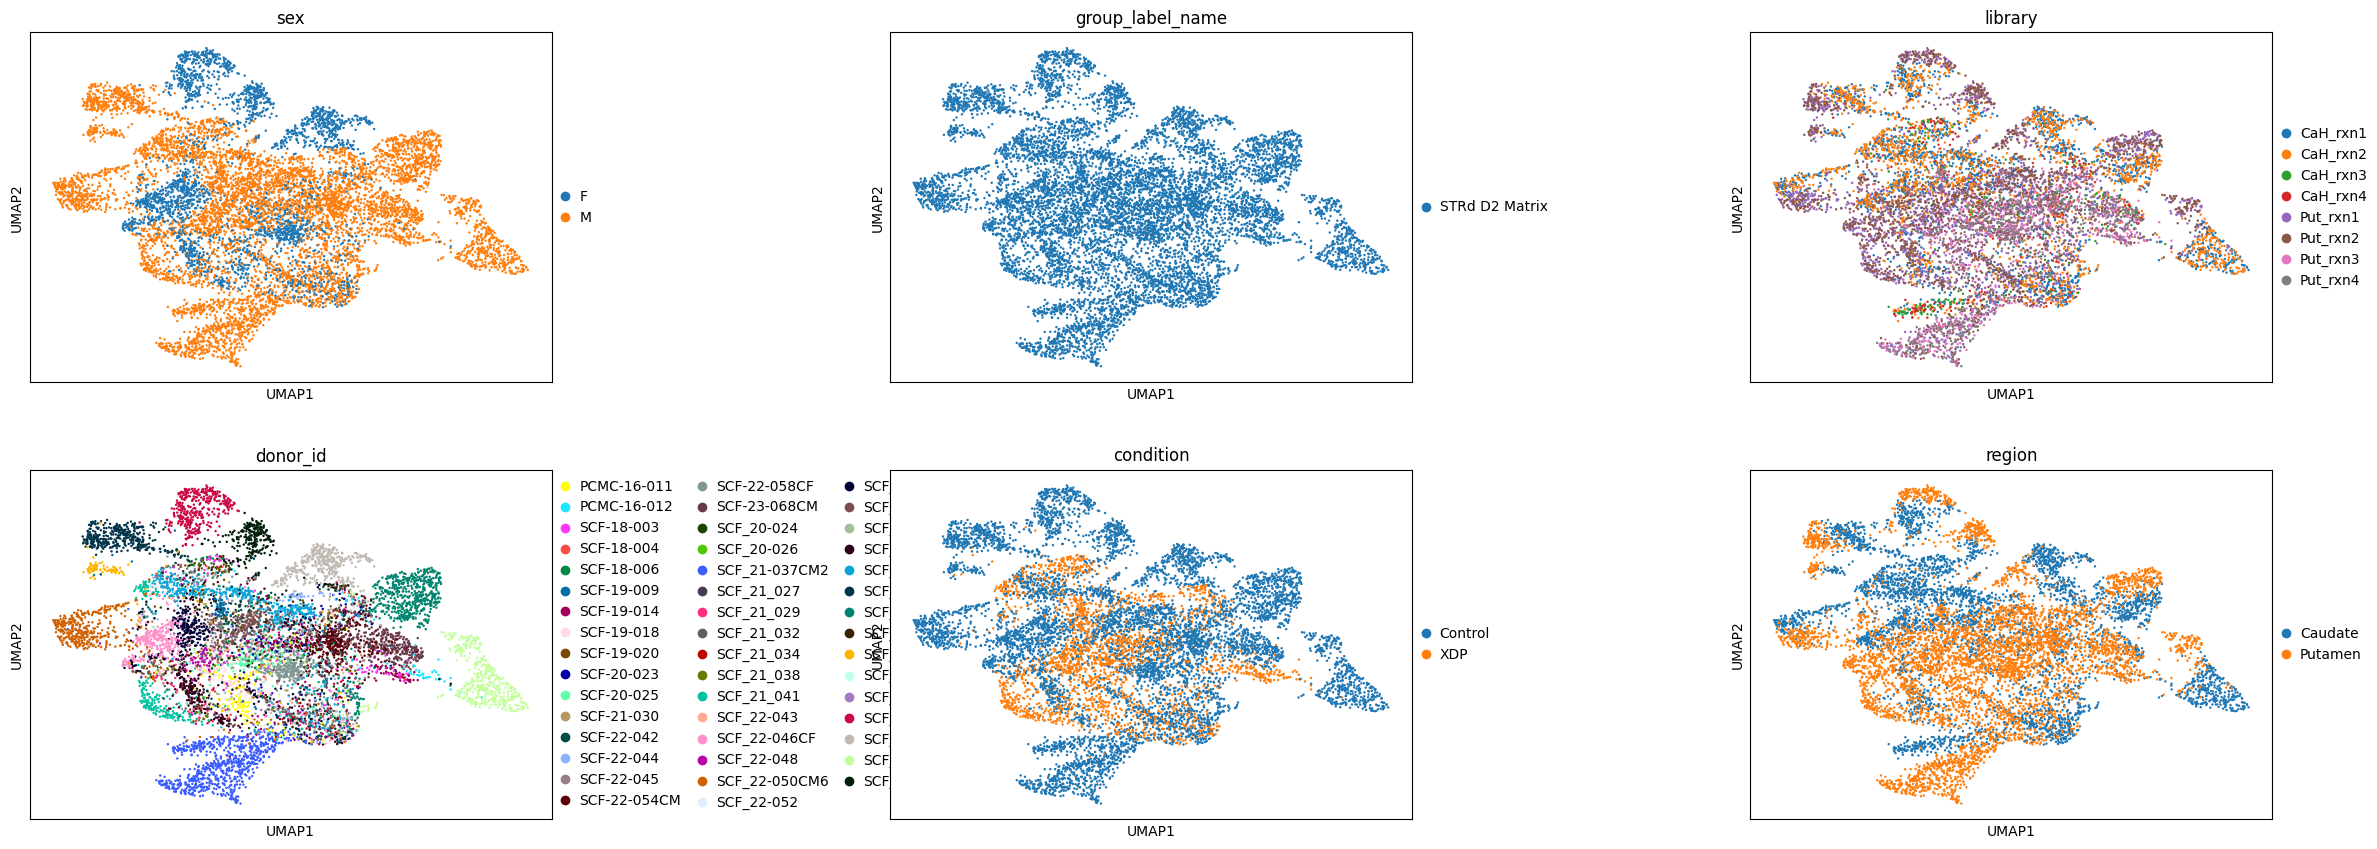

In [7]:
sc.pl.umap(adata, color=["sex", "group_label_name", "library", "donor_id", "condition", "region"], ncols=3, wspace=0.5)

In [8]:
# Create CINEMA-OT model instance
cot = pt.tl.Cinemaot()

# Create cov col
COVARIATES = ["sex","region"] 
adata.obs["cov_col"] = adata.obs[COVARIATES].astype(str).agg("_".join, axis=1)

# Run PCA before

# Main CINEMA-OT analysis
de = cot.causaleffect(
    adata,                              # Your AnnData object
    pert_key="condition",               # Column in .obs with conditions
    control="Control",                  # Name of control condition
    return_matching=True,               # Return matching matrix
    thres=0.5,                          # Signal filtering threshold (0.05-0.75)
    smoothness=1e-5,                    # OT smoothness parameter
    eps=1e-3,                           # Convergence tolerance
    solver="Sinkhorn",                  # OT solver
    #    dim=30,                          # Number of ICA components

    # k=20,                               # k-NN for alignment (only if weighted)
    # resolution=1.0,                      # Leiden clustering resolution (only if weighted)

    
    preweight_label="cov_col"           # COVARIATES (concatenated in single col), what to balnace
)

# de
    # ONLY DISEASED CELLS
    # de.X --> ITE matrix
    # de.obsm['X_embedding'] --> Low-dim ITE embedding
    # de.obsm['ot'] --> Matching matrix 
# adata.obsm['cf'] --< Confounder embedding -_> Added to original adata

INFO:2026-01-20 19:35:37,088:jax._src.xla_bridge:810: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2026-01-20 19:35:37 | [INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2026-01-20 19:35:37 | [WARNING] An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


... storing 'cov_col' as categorical


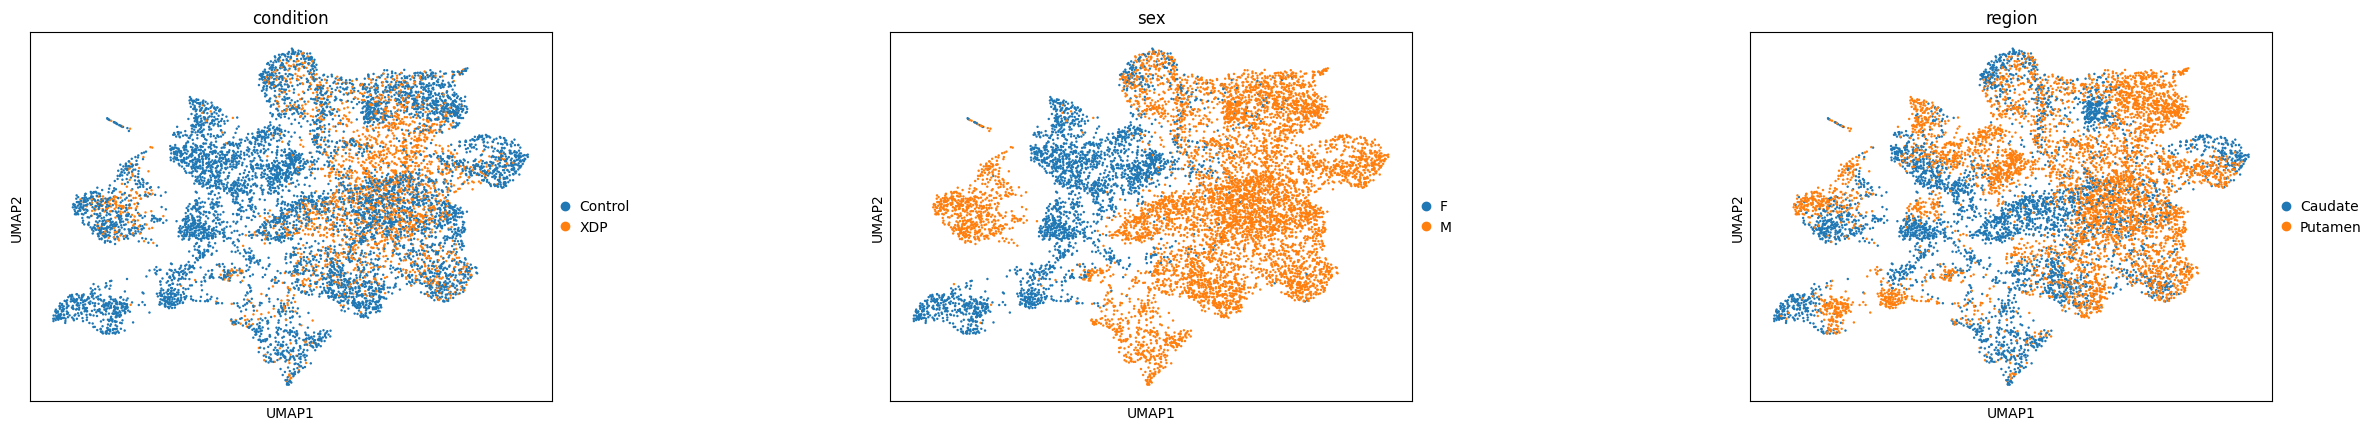

In [9]:
# UMAP of confounder space - healthy and diseased should mix!
    # Goal see if constion is well mixed
sc.pp.neighbors(adata, use_rep="cf")  # Use confounder embedding
sc.tl.umap(adata)
sc.pl.umap(
    adata, 
    color=["condition", *COVARIATES], 
    wspace=0.5,
    #title=["Condition (should mix)", "Cell type (should separate)"]
)

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pertpy/tools/_cinemaot.py:697: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(de, resolution=resolution)


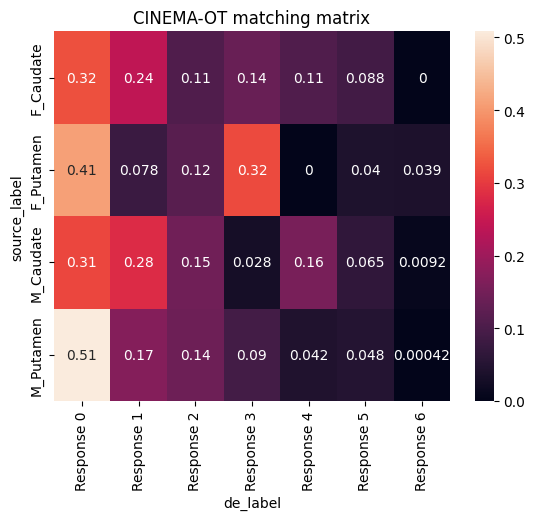

In [10]:
# Aggregated) matching matrix
    # Response N = Leiden clusters of the ITE matrix (diseased cells)
    # M["F_Putamen", "Response 1"] = 0.41 --> 41% of the total matching probability mass from F_Putamen healthy cells goes to diseased cells that are in Response cluster 1
    # Suggests that baseline characteristics of F_Putamen cells predispose them to develop Response 1 when diseased
cot.plot_vis_matching(
    adata,
    de,
    pert_key="condition",
    control="Control",
    de_label=None,
    source_label="cov_col",  
    normalize="row",
    min_val=0.05
)

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[g

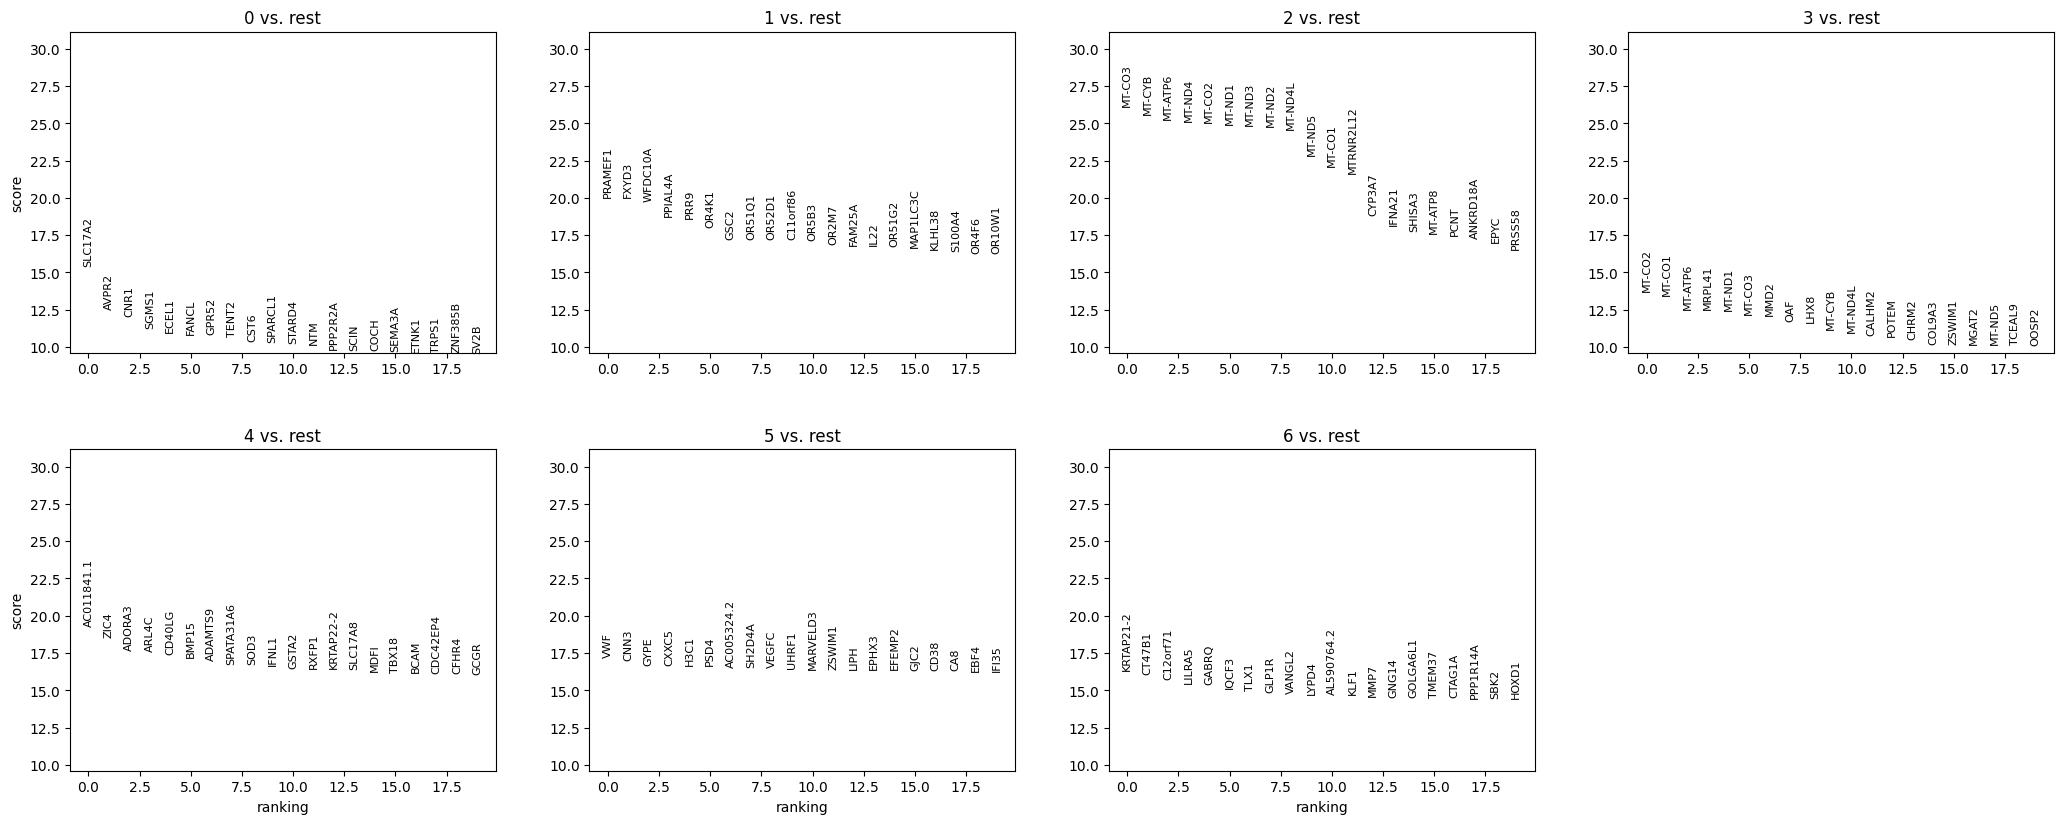

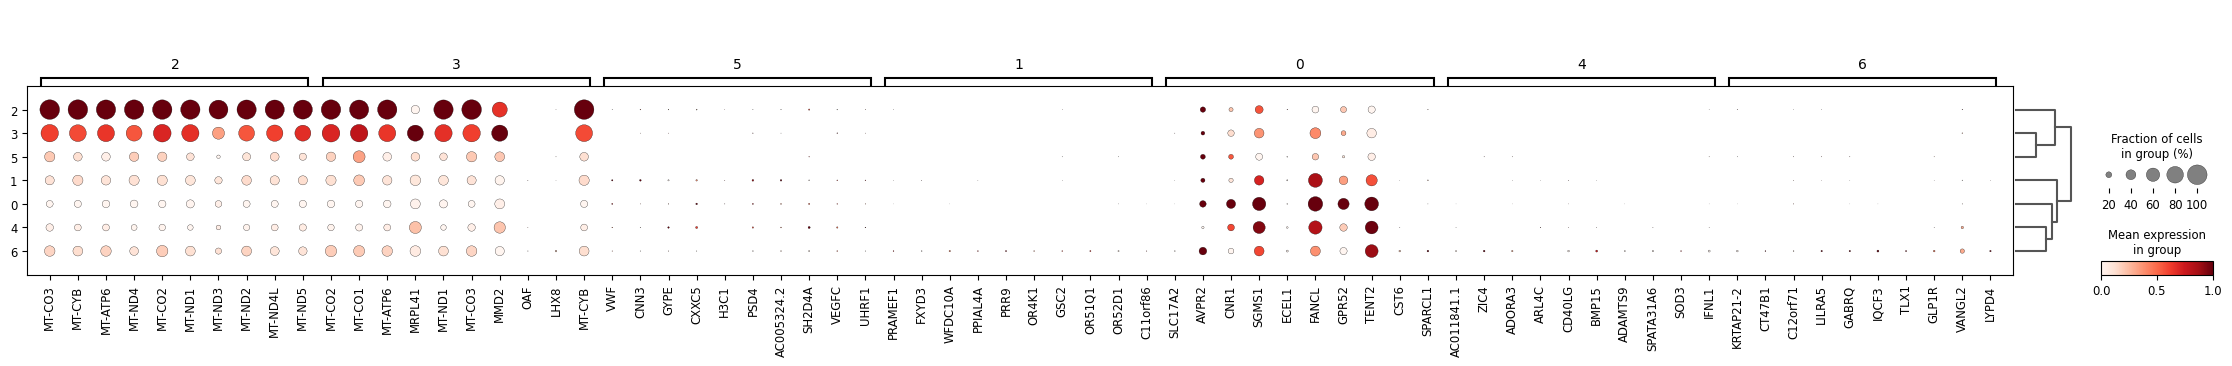

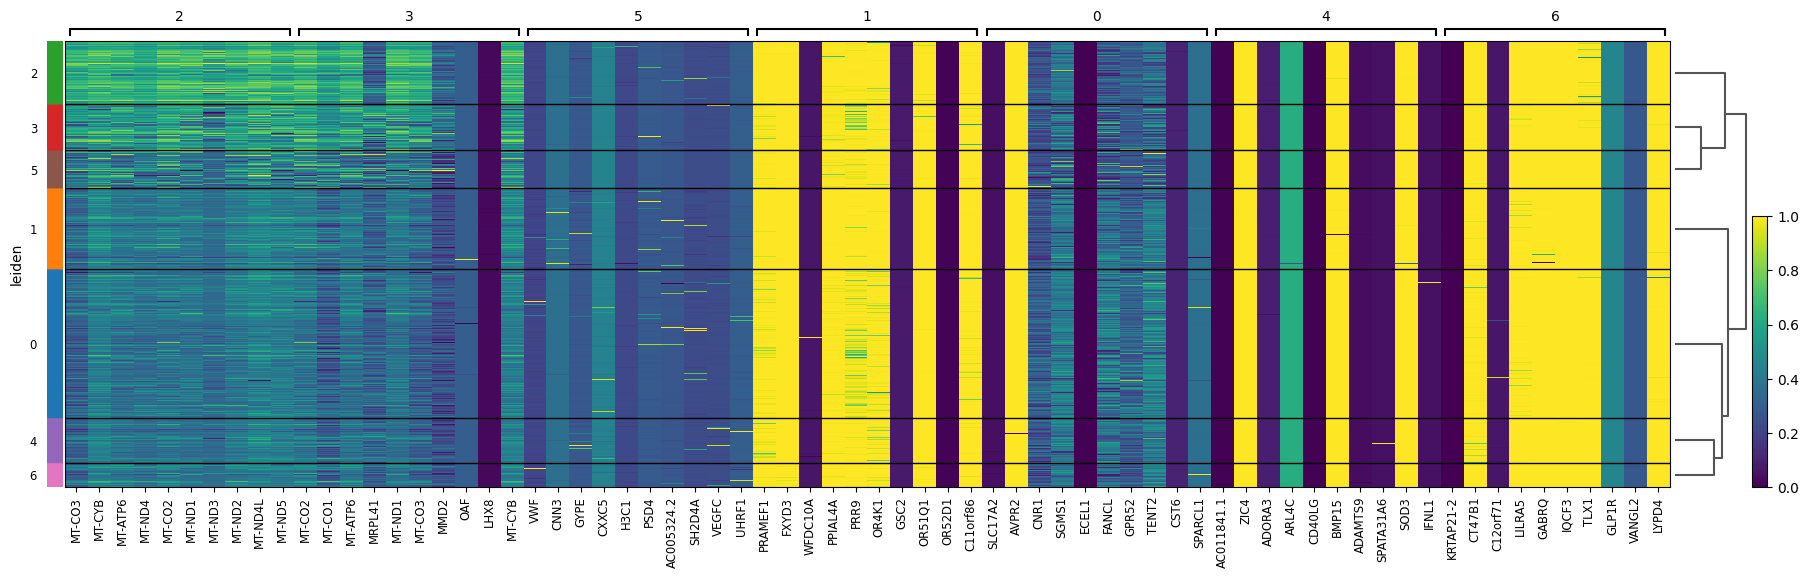

In [21]:
sc.tl.rank_genes_groups(de, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(de, n_genes=20)
sc.pl.rank_genes_groups_dotplot(
    de,
    n_genes=10,
    groupby="leiden",
    standard_scale="var"
)
sc.pl.rank_genes_groups_heatmap(
    de,
    n_genes=10,
    groupby="leiden",
    standard_scale="var",
    show_gene_labels=True
)


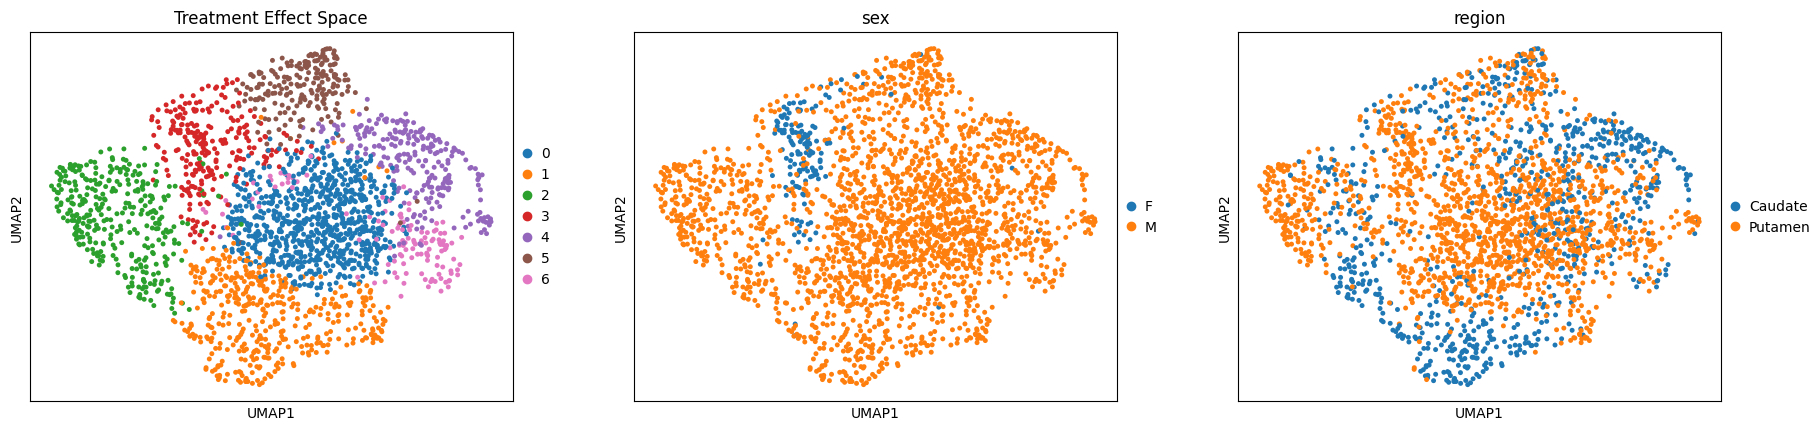

In [18]:
# UMAP of ITE matrix
sc.pp.neighbors(de, use_rep="X_embedding")
sc.tl.umap(de)


# Plot treatment effects
sc.pl.umap(
    de,
    color=["leiden",*COVARIATES],  # or specific genes
    title="Treatment Effect Space"
)

In [19]:
de

AnnData object with n_obs × n_vars = 2360 × 19967
    obs: 'orig.ident', 'ncount_rna', 'nfeature_rna', 'cell', 'donor_id', 'prob_max', 'numi', 'nread', 'pct_intronic', 'pct_mito', 'library', 'region', 'rna_snn_res.0.2', 'seurat_clusters', 'rna_snn_res.0.3', 'rna_snn_res.0.4', 'rna_snn_res.0.5', 'rna_snn_res.0.6', 'rna_snn_res.0.7', 'rna_snn_res.0.8', 'rna_snn_res.0.9', 'rna_snn_res.1', 'rna_snn_res.0.05', 'rna_snn_res.0.1', 'brain_bank', 'cohort', 'year_collected', 'repeat_length', 'age_of_onset', 'age_of_death', 'disease_duration', 'rqs', 'dv200', 'ph', 'mqs_numerical', 'mqs', 'immediate.cause.of.death', 'infection_related_death', 'sex', 'condition', 'library_cohort', 'cell_id', 'class_label_name', 'class_label_bootstrapping_probability', 'subclass_label_name', 'subclass_label_bootstrapping_probability', 'group_label_name', 'group_label_bootstrapping_probability', 'cluster_label_name', 'cluster_label_bootstrapping_probability', 'cell_class', 'neuron_cell_class', 'phase_c_plus_UCell__R